In [2]:
from utils import read_examples, find_similar_message
filename = '/mnt/ssd2/rambo/data/come_data/summarize/java/train.jsonl'
examples = read_examples(filename, -1, 'summarize')
examples = find_similar_message(examples, examples, k=1)

Retrieving with TF-IDF: 100%|██████████| 75000/75000 [1:09:16<00:00, 18.04it/s]


In [1]:
import os
os.environ['HUGGINGFACE_CO_RESOLVE_ENDPOINT'] = 'https://hf-mirror.com'
from transformers import AutoTokenizer

# 加载预训练的 tokenizer
tokenizer = AutoTokenizer.from_pretrained("Salesforce/codet5-base")

# 添加新的特殊 token
special_tokens_dict = {'additional_special_tokens': ['<diff>', '<msg>']}
tokenizer.add_special_tokens(special_tokens_dict)

# 获取 `<diff>` 和 `<msg>` 的 token ID
diff_token_id = tokenizer.convert_tokens_to_ids('<diff>')
msg_token_id = tokenizer.convert_tokens_to_ids('<msg>')

print(f"<diff> token ID: {diff_token_id}")
print(f"<msg> token ID: {msg_token_id}")


/home/rambo/miniconda3/envs/come/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<diff> token ID: 32100
<msg> token ID: 32101


In [2]:
def calcu_edit_distance(del_token, add_token):
    ''' What operation did del_token become add_token through '''

    m = len(del_token)
    n = len(add_token)
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    for i in range(1, m + 1):
        dp[i][0] = i

    for j in range(1, n + 1):
        dp[0][j] = j

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if del_token[i - 1] == add_token[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = min(dp[i - 1][j - 1], dp[i - 1][j], dp[i][j - 1]) + 1

    i = len(dp) - 1
    j = len(dp[0]) - 1
    res = []
    while i > 0 or j > 0:
        a = dp[i - 1][j - 1] if i > 0 and j > 0 else float("inf")
        b = dp[i - 1][j] if i > 0 else float("inf")
        c = dp[i][j - 1] if j > 0 else float("inf")
        min_val = min([a, b, c])

        if dp[i][j] == a and a == min_val:
            i -= 1
            j -= 1
            assert del_token[i] == add_token[j]
            res.append((del_token[i], 0)) # ori
        elif a == min([a, b, c]):
            i -= 1
            j -= 1
            res.append((add_token[j], 2)) # add
            res.append((del_token[i], 1)) # del
        elif b == min([a, b, c]):
            i = i - 1
            res.append((del_token[i], 1)) # del
        else:
            j = j - 1
            res.append((add_token[j], 2)) # add
    res = res[::-1]
    res_token = [r[0] for r in res]
    res_tag =  [r[1] for r in res]
    return res_token, res_tag

del_token = ['a', 'b', 'c']
add_token = ['a','d','c']
calcu_edit_distance(del_token, add_token)

(['a', 'b', 'd', 'c'], [0, 1, 2, 0])

In [4]:
%pip install networkx


Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
     |████████████████████████████████| 1.6 MB 221 kB/s eta 0:00:01
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1
Note: you may need to restart the kernel to use updated packages.


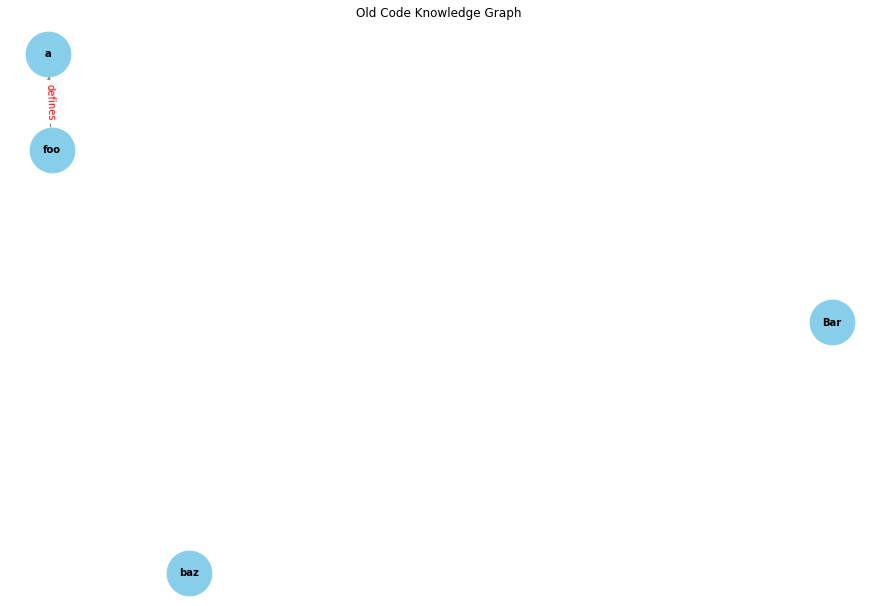

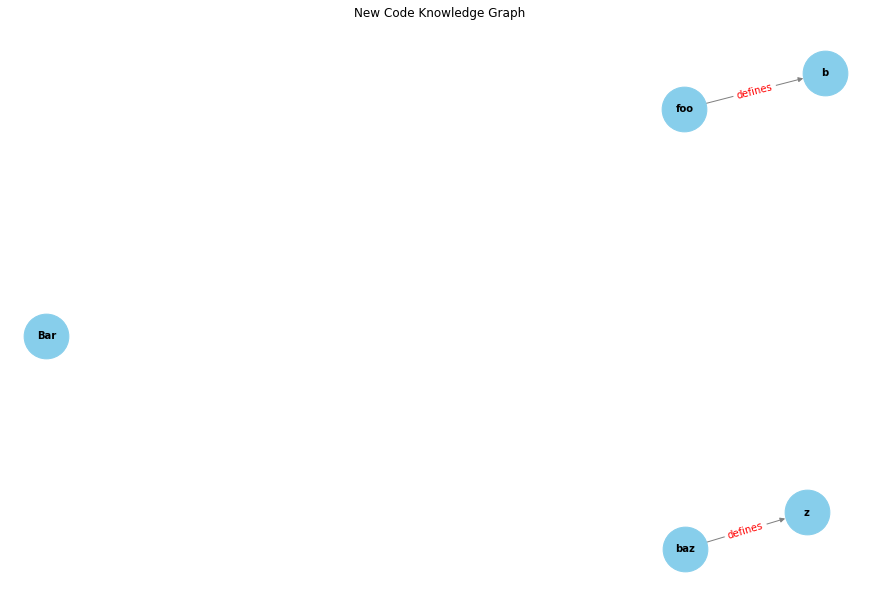

In [5]:
import ast
import networkx as nx
import matplotlib.pyplot as plt

# 解析代码并构建AST
def parse_code_to_ast(code):
    return ast.parse(code)

# 提取AST中的实体和关系
def extract_entities_and_relations(ast_tree):
    entities = []
    relations = []
    
    class CodeVisitor(ast.NodeVisitor):
        def visit_FunctionDef(self, node):
            entities.append(('function', node.name))
            for stmt in node.body:
                if isinstance(stmt, ast.Assign):
                    for target in stmt.targets:
                        if isinstance(target, ast.Name):
                            relations.append((node.name, 'defines', target.id))
            self.generic_visit(node)

        def visit_ClassDef(self, node):
            entities.append(('class', node.name))
            self.generic_visit(node)

        def visit_Call(self, node):
            if isinstance(node.func, ast.Name):
                relations.append((node.func.id, 'calls', node.func.id))
            self.generic_visit(node)

    CodeVisitor().visit(ast_tree)
    return entities, relations

# 构建知识图谱
def build_knowledge_graph(entities, relations):
    graph = nx.DiGraph()
    for entity in entities:
        graph.add_node(entity[1], type=entity[0])
    for relation in relations:
        graph.add_edge(relation[0], relation[2], type=relation[1])
    return graph

# 旧代码
old_code = """
def foo(x):
    a = x + 1
    return a

class Bar:
    def baz(self, y):
        return y * 2
"""

# 新代码
new_code = """
def foo(x):
    b = x + 2
    return b

class Bar:
    def baz(self, y):
        z = y * 2
        return z
"""

# 解析和提取实体关系
old_ast = parse_code_to_ast(old_code)
new_ast = parse_code_to_ast(new_code)

old_entities, old_relations = extract_entities_and_relations(old_ast)
new_entities, new_relations = extract_entities_and_relations(new_ast)

# 构建知识图谱
old_graph = build_knowledge_graph(old_entities, old_relations)
new_graph = build_knowledge_graph(new_entities, new_relations)

# 可视化知识图谱
def visualize_graph(graph, title):
    pos = nx.spring_layout(graph)
    plt.figure(figsize=(12, 8))
    nx.draw(graph, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
    edge_labels = nx.get_edge_attributes(graph, 'type')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_color='red')
    plt.title(title)
    plt.show()

visualize_graph(old_graph, 'Old Code Knowledge Graph')
visualize_graph(new_graph, 'New Code Knowledge Graph')


In [6]:
def compare_knowledge_graphs(old_graph, new_graph):
    added_nodes = set(new_graph.nodes()) - set(old_graph.nodes())
    removed_nodes = set(old_graph.nodes()) - set(new_graph.nodes())
    
    added_edges = set(new_graph.edges()) - set(old_graph.edges())
    removed_edges = set(old_graph.edges()) - set(new_graph.edges())
    
    return added_nodes, removed_nodes, added_edges, removed_edges

added_nodes, removed_nodes, added_edges, removed_edges = compare_knowledge_graphs(old_graph, new_graph)

print("Added Nodes:", added_nodes)
print("Removed Nodes:", removed_nodes)
print("Added Edges:", added_edges)
print("Removed Edges:", removed_edges)


Added Nodes: {'b', 'z'}
Removed Nodes: {'a'}
Added Edges: {('baz', 'z'), ('foo', 'b')}
Removed Edges: {('foo', 'a')}
